In [1]:
#my modules
import os
os.chdir("..")

In [2]:
from bass_lv_v2 import SVBassLV
from utils import Density, mc_iv, bs_call_price
from reference_models import BrownianMotion_R
from plot import plot_bass_result
from scipy.interpolate import interp1d

#modules
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import data as dt
from svi import SVI

os.chdir("./data")

In [3]:
#download data
data = dt.YFinanceData.load_from_disk("spx-2024-02-20.xlsx")
min_abs_delta = 0.01

print(f"Date: {data.access_time.tz_convert('America/New_York').date()}") 
print("Available maturities:", ", ".join(str(m) for m in data.get_maturities()))

maturities = ["2024-02-23", "2024-03-01", "2024-03-08", "2024-03-15", "2024-03-22"] + [str(m) for m in data.get_maturities()[28:]]
print("Maturities we'll use:", ", ".join(maturities))

Date: 2024-02-20
Available maturities: 2024-02-20, 2024-02-21, 2024-02-22, 2024-02-23, 2024-02-26, 2024-02-27, 2024-02-28, 2024-02-29, 2024-03-01, 2024-03-04, 2024-03-05, 2024-03-06, 2024-03-07, 2024-03-08, 2024-03-11, 2024-03-12, 2024-03-13, 2024-03-14, 2024-03-15, 2024-03-18, 2024-03-19, 2024-03-20, 2024-03-21, 2024-03-22, 2024-03-25, 2024-03-26, 2024-03-27, 2024-03-28, 2024-04-05, 2024-04-19, 2024-04-30, 2024-05-17, 2024-05-31, 2024-06-21, 2024-06-28, 2024-07-19, 2024-07-31, 2024-08-16, 2024-09-20, 2024-09-30, 2024-10-18, 2024-11-15, 2024-12-20, 2024-12-31, 2025-01-17, 2025-02-21, 2025-03-21, 2025-06-20, 2025-12-19
Maturities we'll use: 2024-02-23, 2024-03-01, 2024-03-08, 2024-03-15, 2024-03-22, 2024-04-05, 2024-04-19, 2024-04-30, 2024-05-17, 2024-05-31, 2024-06-21, 2024-06-28, 2024-07-19, 2024-07-31, 2024-08-16, 2024-09-20, 2024-09-30, 2024-10-18, 2024-11-15, 2024-12-20, 2024-12-31, 2025-01-17, 2025-02-21, 2025-03-21, 2025-06-20, 2025-12-19


In [4]:
S0 = 4975.85

#unpack the datasrame for separate arrays fro calibration 
T, F, X, K, W, IV = [], [], [], [], [], []

for m in maturities:
    T.append(data.forward_prices.loc[m].timeToMaturity)
    F.append(data.forward_prices.loc[m].forwardPrice)
    x, w = data.get_implied_vol(m, min_abs_delta=min_abs_delta, return_total_var=True, as_numpy=True)
    k, iv = data.get_implied_vol(m, min_abs_delta=min_abs_delta, return_total_var=False, as_numpy=True)
    X.append(x)
    W.append(w)
    K.append(k)
    IV.append(iv)

In [5]:
# SVI MODEL CALIBRATION - RAW MARKET MARGINALS
svi_models = {}
market_marginals = {}

for i in range(len(T)):
    maturity_time = T[i]
    forward_price = F[i]
    x = X[i]  
    w = W[i]  
    
    svi_model = SVI.calibrate(x, w, no_arbitrage=False)
    svi_models[maturity_time] = svi_model
    
    s_min = forward_price * 0.2
    s_max = forward_price * 5.0
    n_points = 10000
    s_grid = np.linspace(s_min, s_max, n_points)
    
    cdf_values = svi_model.cdf(S0, s_grid)
    cdf_values[np.isclose(cdf_values, 0, atol=0.00001)] = 0
    cdf_values[np.isclose(cdf_values, 1, atol=0.00001)] = 1
    cdf_values = np.clip(cdf_values, 0, 1)
    
    cdf_func = interp1d(s_grid, cdf_values, bounds_error=False, fill_value=(0, 1), kind='linear')
    qf_func = interp1d(cdf_values, s_grid, bounds_error=False, fill_value='extrapolate', kind='linear')

    density = Density(cdf=cdf_func, qf=qf_func)
    market_marginals[maturity_time] = density

    prob_grid = np.linspace(0.001, 0.999, 1000)
    s_samples = qf_func(prob_grid)
    expectation = np.trapz(s_samples, prob_grid)
    
    print(f"T={maturity_time:.4f}, F={forward_price:.2f}, E[S]={expectation:.2f}")

print(f"Calibrated {len(market_marginals)} SVI models")

T=0.0088, F=4979.50, E[S]=4966.48
T=0.0280, F=4981.40, E[S]=4966.86
T=0.0471, F=4985.95, E[S]=4967.06
T=0.0662, F=4988.80, E[S]=4967.19
T=0.0854, F=4994.70, E[S]=4967.27
T=0.1237, F=5001.74, E[S]=4967.36
T=0.1621, F=5012.43, E[S]=4967.48
T=0.1922, F=5018.22, E[S]=4967.65
T=0.2388, F=5028.86, E[S]=4967.59
T=0.2772, F=5037.88, E[S]=4967.57
T=0.3347, F=5049.31, E[S]=4967.53
T=0.3539, F=5052.75, E[S]=4967.48
T=0.4114, F=5066.92, E[S]=4967.65
T=0.4443, F=5073.00, E[S]=4967.55
T=0.4881, F=5080.26, E[S]=4967.79
T=0.5840, F=5099.18, E[S]=4968.14
T=0.6114, F=5104.31, E[S]=4967.82
T=0.6607, F=5116.98, E[S]=4970.17
T=0.7376, F=5131.31, E[S]=4968.30
T=0.8334, F=5147.60, E[S]=4968.21
T=0.8636, F=5152.78, E[S]=4968.22
T=0.9102, F=5166.64, E[S]=4968.36
T=1.0060, F=5179.14, E[S]=4968.10
T=1.0826, F=5192.37, E[S]=4967.94
T=1.3320, F=5236.16, E[S]=4967.87
T=1.8307, F=5308.22, E[S]=4966.65
Calibrated 26 SVI models


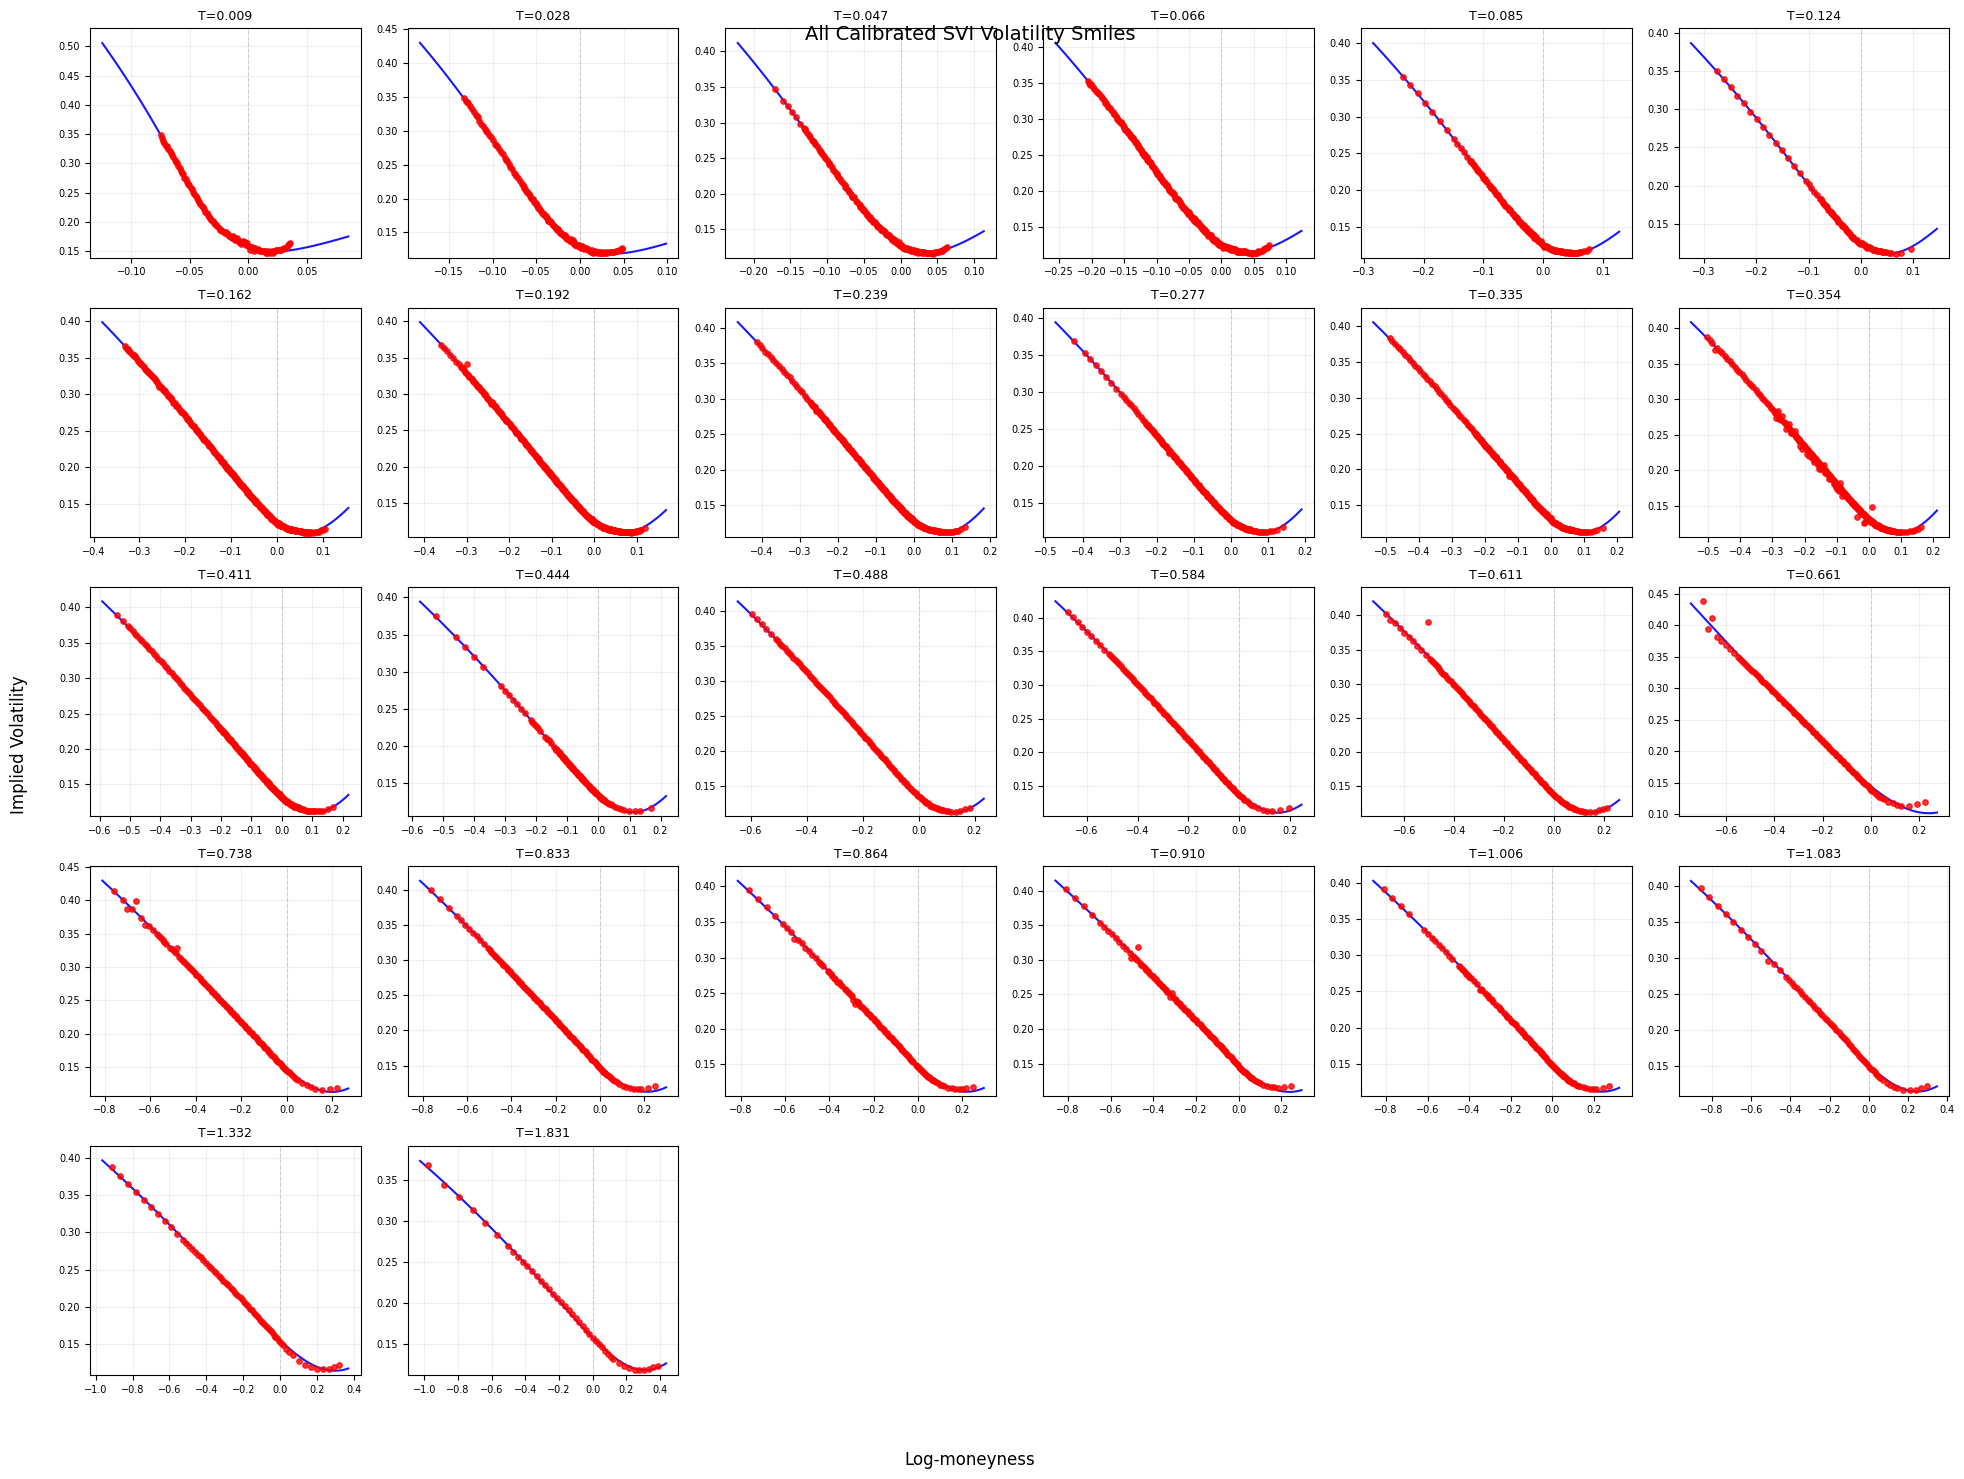

In [6]:
# CALIBRATED SVI SMILES VISUALIZATION - ALL MATURITIES
n_maturities = len(T)
n_cols = 6
n_rows = int(np.ceil(n_maturities / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
axes = axes.flatten() if n_maturities > 1 else [axes]

for i in range(n_maturities):
    ax = axes[i]
    
    maturity_time = T[i]
    forward_price = F[i]
    x_market = X[i]  # Market log-moneyness
    iv_market = IV[i]  # Market implied volatilities
    svi_model = svi_models[maturity_time]
    
    # Create fine grid for smooth SVI curve
    x_fine = np.linspace(x_market.min() - 0.05, x_market.max() + 0.05, 100)
    iv_svi = np.sqrt(svi_model.total_var(x_fine) / maturity_time)
    
    # Plot market data points
    ax.scatter(x_market, iv_market, color='red', s=15, alpha=0.8, zorder=5)
    ax.plot(x_fine, iv_svi, 'blue', linewidth=1.5, alpha=0.9)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Compact formatting
    ax.set_title(f'T={maturity_time:.3f}', fontsize=9)
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.2)
    
    # Set reasonable y-axis limits
    y_min = min(iv_market.min(), iv_svi.min()) * 0.95
    y_max = max(iv_market.max(), iv_svi.max()) * 1.05
    ax.set_ylim(y_min, y_max)

# Remove empty subplots
for i in range(n_maturities, len(axes)):
    axes[i].remove()

# Add common labels
fig.text(0.5, 0.02, 'Log-moneyness', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Implied Volatility', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08, left=0.06)
plt.suptitle('All Calibrated SVI Volatility Smiles', fontsize=14, y=0.98)
plt.show()


In [7]:
# BASS LOCAL VOLATILITY MODEL CALIBRATION
filtered_marginals = {t: density for t, density in market_marginals.items() if t >= 0.1237}

S0_bass = 4975.85
reference_model = BrownianMotion_R(S0_bass, 1)
bass_model = SVBassLV(S0_bass, reference_model, filtered_marginals)

calibration_results = bass_model.calibrate(tolerance = 0.001, max_iter = 100, N = 10_000, nsigma = 7)

Interval 1 (T=0.1621): 16 iterations, final error = 0.0009603417619942212
Interval 2 (T=0.1922): 17 iterations, final error = 0.0009713949892570239
Interval 3 (T=0.2388): 16 iterations, final error = 0.0008996272301787789
Interval 4 (T=0.2772): 13 iterations, final error = 0.0009120415173097252
Interval 5 (T=0.3347): 14 iterations, final error = 0.0009987079748750016
Interval 6 (T=0.3539): 6 iterations, final error = 0.0009908790488889485
Interval 7 (T=0.4114): 7 iterations, final error = 0.0008216909814247053
Interval 8 (T=0.4443): 10 iterations, final error = 0.0009651144122472255
Interval 9 (T=0.4881): 12 iterations, final error = 0.000859180407135729
Interval 10 (T=0.584): 13 iterations, final error = 0.0007982196992282198
Interval 11 (T=0.6114): 86 iterations, final error = 0.0002500407959518114
Interval 12 (T=0.6607): 55 iterations, final error = 2.9575210184346057e-05
Interval 13 (T=0.7376): 99 iterations, final error = 0.0021150832568736047
Interval 14 (T=0.8334): 41 iterations

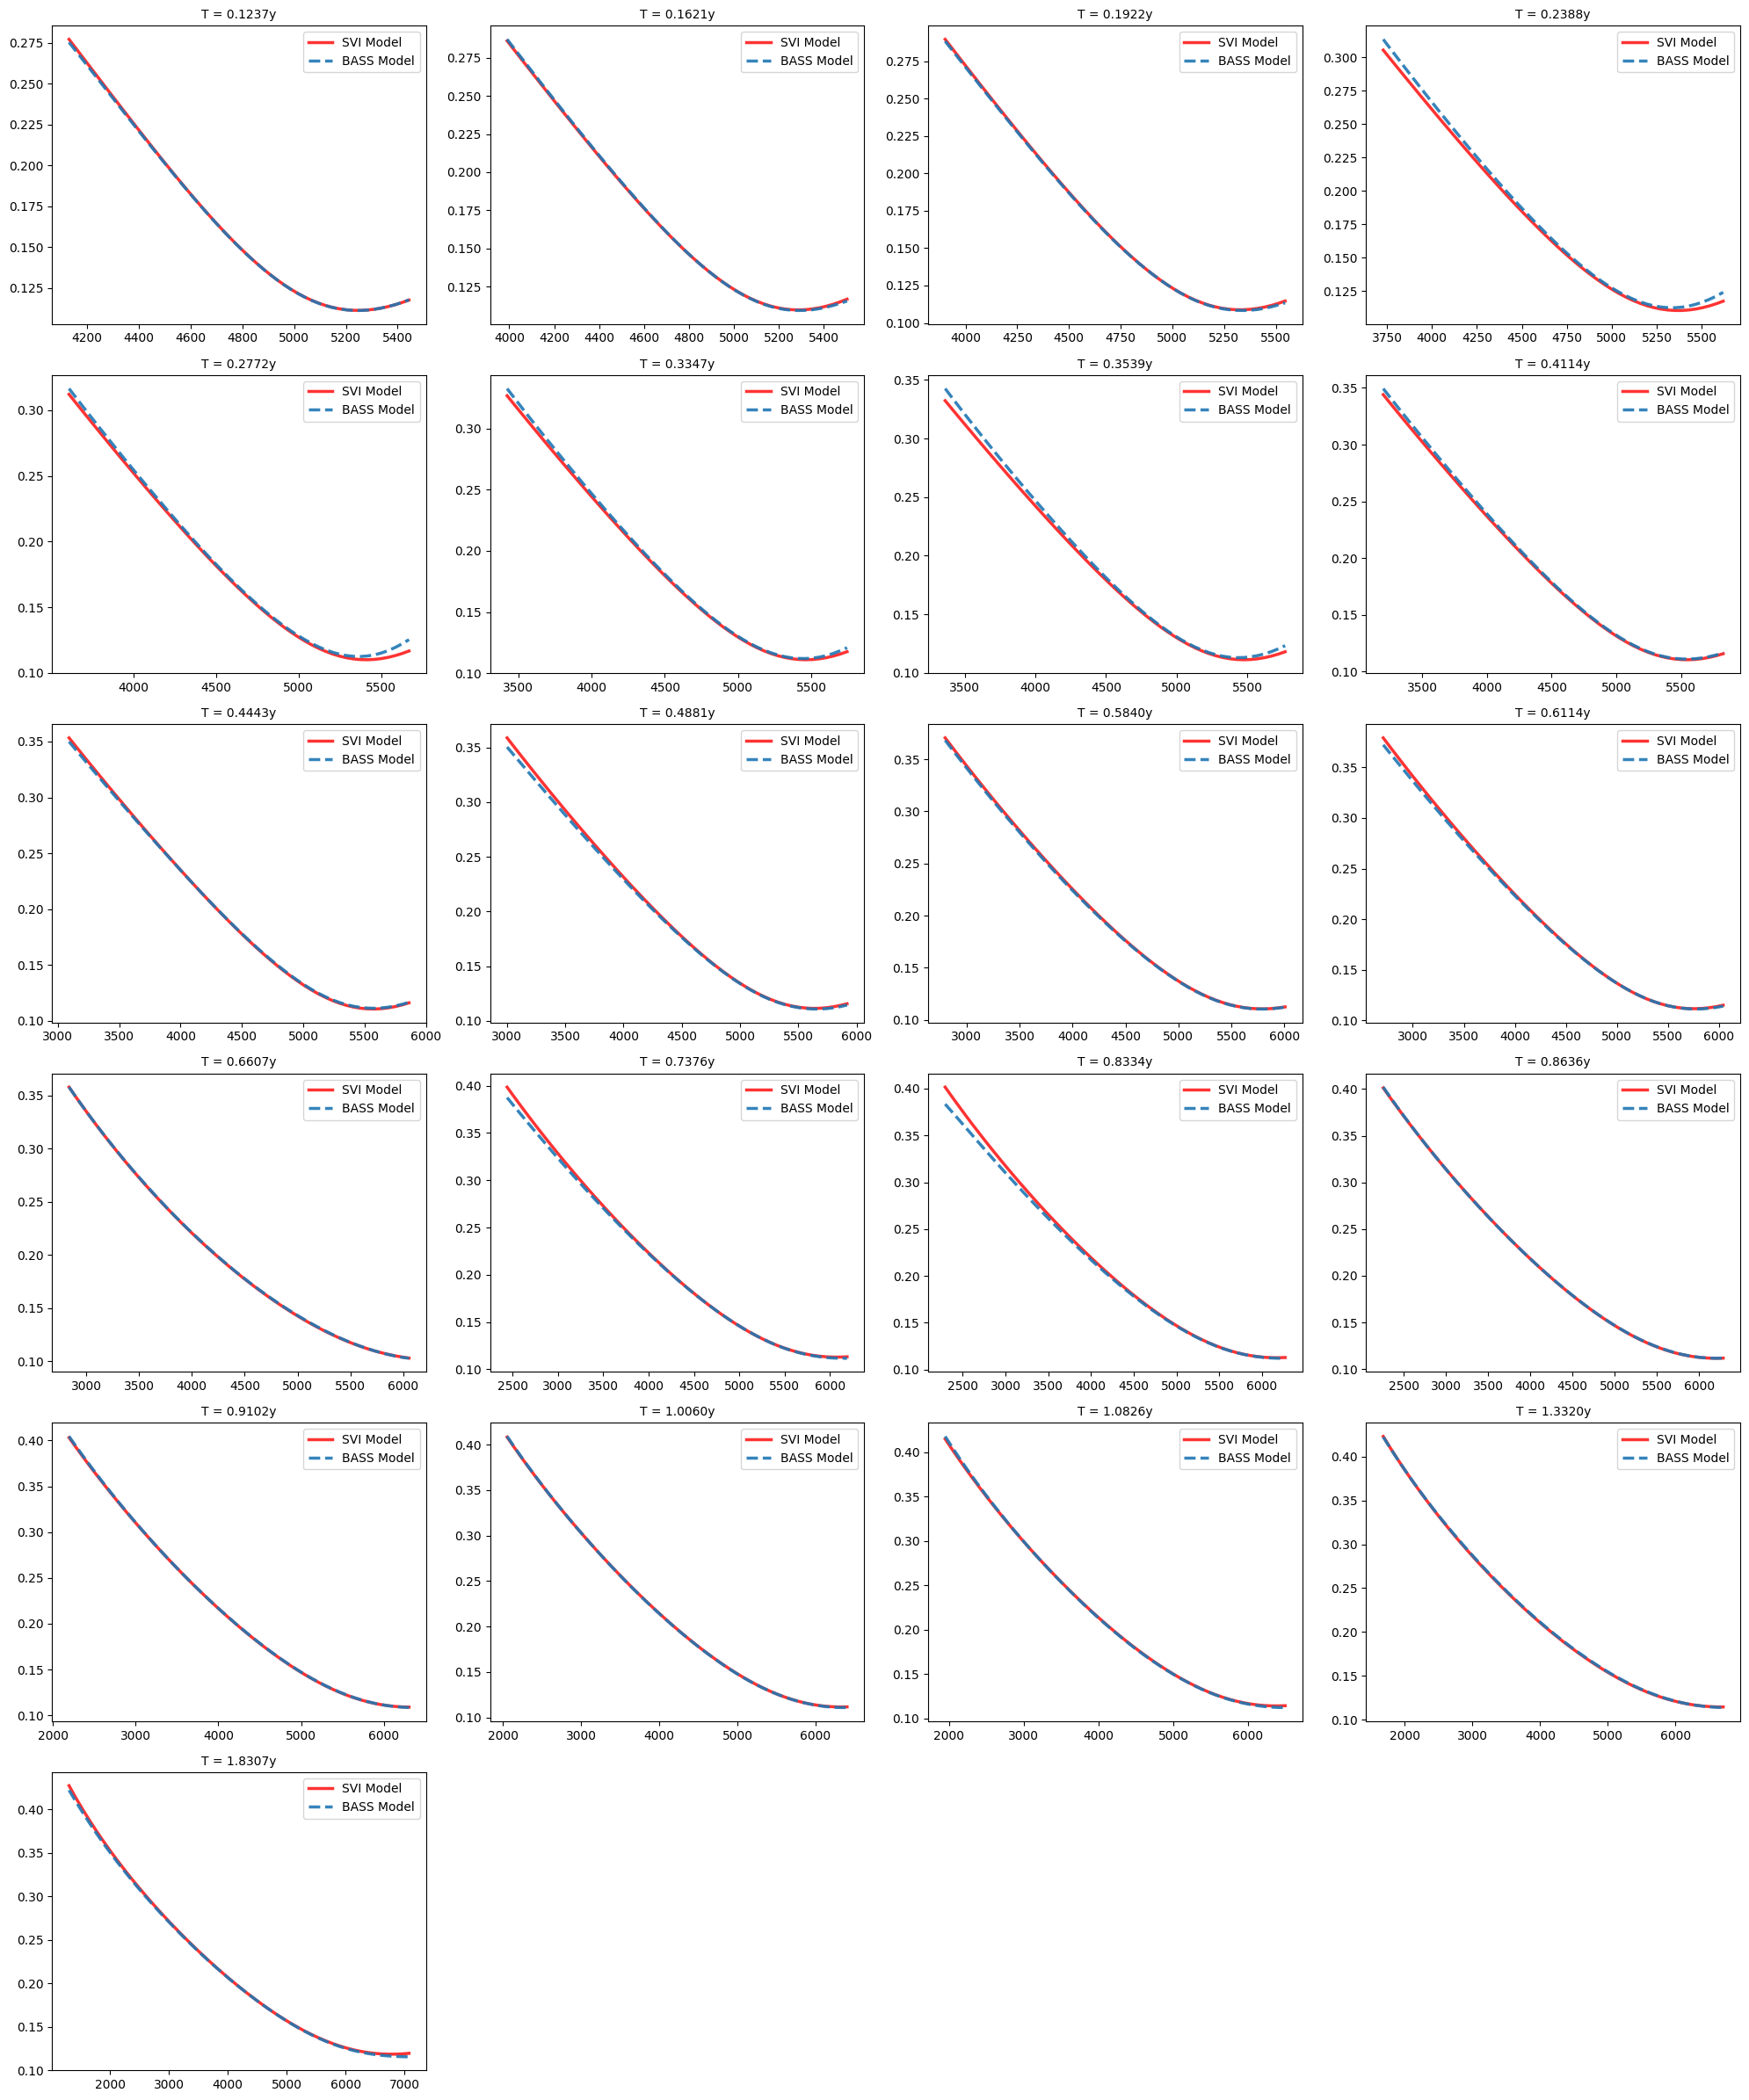

In [ ]:
# All maturities starting from 0.1237
all_maturities = [t for t in T if t >= 0.1237]
selected_maturities = sorted(all_maturities)

# Create the comparison plot with all maturities
n_maturities = len(selected_maturities)
n_cols = 4
n_rows = int(np.ceil(n_maturities / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten() if n_maturities > 1 else [axes]

for i, maturity_time in enumerate(selected_maturities):
    ax = axes[i]
    
    # Get market data for this maturity
    maturity_idx = T.index(maturity_time)
    x_market = X[maturity_idx]
    iv_market = IV[maturity_idx]
    forward_price = F[maturity_idx]
    
    svi_model = svi_models[maturity_time]

    strike_min = filtered_marginals[maturity_time].qf(0.01)
    strike_max = filtered_marginals[maturity_time].qf(0.99)
    n_strikes = 50
    K_plot = np.linspace(strike_min, strike_max, n_strikes)

    iv_svi = svi_model.implied_vol(S0, maturity_time, K_plot)

    n_paths = 300_000
    bass_paths = bass_model.simulate_smile(n_paths, maturity_time)
    iv_bass = mc_iv(S0, maturity_time, K_plot, bass_paths)

    ax.plot(K_plot, iv_svi, 'r-', linewidth=2.5, alpha=0.8, label='SVI Model')
    ax.plot(K_plot, iv_bass, linestyle='--', linewidth=2.5, alpha=0.9, label='BASS Model')
    ax.set_title(f'T = {maturity_time:.4f}y', fontsize=10)
    ax.legend(fontsize=10)

for i in range(n_maturities, len(axes)):
    axes[i].remove()


plt.tight_layout()
plt.show()